<a href="https://colab.research.google.com/github/tyukios/genai/blob/main/hw7_%E6%89%93%E9%80%A0%E7%99%BE%E8%B2%A8%E6%80%AA%E8%AB%87%E7%9A%84RAG%E7%B3%BB%E7%B5%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 0. 主題發想

最初的發想來自於老師上課提供的政大社團資料範例:

    社團編號：B001
    社團名稱：長廊詩社
    社團簡介：政大唯一的純文學社團，設有詩人講座、主題讀詩會，以及作品詩集的互相交流與分享活動。
    相關連結：https://www.facebook.com/longporchpoetrysociety

初次嘗試使用 ChatGPT 小規模生成 RAG 資料庫內容時，我也發現 ChatGPT 生成出使用較為結構化的排版的內容：

    🌀 社團名稱：時間旅行研究社
    成立：2042年（咦？）

    社團簡介：專門研究如何用手作時光機打開不同平行宇宙的大門，據說上屆社長失蹤後就沒再回來。

    成員介紹：

    社長：吳時易（高三，據說他曾經見過未來的自己）

    副社長：林回回（高一，喜歡倒著說話）

    活動紀錄：

    2024.03.14 成功讓一顆雞蛋回到早上9點

    2024.06.06 舉辦平行宇宙交流晚會，出席人數：∞

    社團口號：「回到昨天，創造明天！」

因此這次我選擇以怪談的檢索器為 RAG 的主題，並在指定輸出格式（要求生成**怪談名稱、怪談發生位置、怪談發生時間、讓怪談發生的要素、怪談內容**等項目）的情況下使用 ChatGPT 協助生成資料。

資料庫來源：

https://chatgpt.com/share/67ffd43e-dbec-8001-813f-03de81e8f494

In [1]:
import gdown

In [2]:
#https://drive.google.com/file/d/1-dbrSfBni35ay4YHDwROTgZYKNwYZODL/view?usp=sharing
file_ID='1-dbrSfBni35ay4YHDwROTgZYKNwYZODL'
output_file='faiss_db.zip'
gdown.download(f'https://drive.google.com/uc?id={file_ID}', output_file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-dbrSfBni35ay4YHDwROTgZYKNwYZODL
To: /content/faiss_db.zip
100%|██████████| 44.3k/44.3k [00:00<00:00, 51.5MB/s]


'faiss_db.zip'

In [3]:
!unzip faiss_db.zip

Archive:  faiss_db.zip
   creating: faiss_db/
  inflating: faiss_db/index.faiss    
  inflating: faiss_db/index.pkl      


### 1. 安裝並引入必要套件

In [4]:
!pip install -U langchain langchain-community sentence-transformers faiss-cpu gradio openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/8

In [5]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain

In [6]:
from openai import OpenAI
import gradio as gr

### 2. 自訂 E5 embedding 類別

In [7]:
class CustomE5Embedding(HuggingFaceEmbeddings):
    def embed_documents(self, texts):
        texts = [f"passage: {t}" for t in texts]
        return super().embed_documents(texts)

    def embed_query(self, text):
        return super().embed_query(f"query: {text}")

### 3. 載入 `faiss_db`

In [8]:
embedding_model = CustomE5Embedding(model_name="intfloat/multilingual-e5-small")
db = FAISS.load_local("faiss_db", embedding_model, allow_dangerous_deserialization=True)
retriever = db.as_retriever()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/498k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

### 4. 設定 LLM 環境

In [9]:
import os
from google.colab import userdata

In [10]:
api_key = userdata.get('Groq')

In [11]:
os.environ["OPENAI_API_KEY"] = api_key

In [12]:
model = "llama3-70b-8192"
base_url="https://api.groq.com/openai/v1"

In [13]:
client = OpenAI(
    base_url=base_url
)

### 5. `prompt` 設計

人設的設計上，我以「百貨公司的資深人員」的概念出發，希望能表現出**講故事的親切感**，後續也以此作為修訂 prompt 的標準。

- 第一版的 prompt

    
    你是一位在百貨公司工作超過三十年的退休老員工，曾經做過守衛、清潔工、還有一段時間幫忙管理後台的檔案室。退休後你負責保存與記錄百貨公司裡發生過的「怪談事件」。你語氣親切、像是長輩說故事，有時有點嘮叨，但你對百貨的各個區域、樓層時間點都瞭若指掌。當使用者提問時，你會從你保存的資料中調閱出事件，搭配你自己的記憶或評論補充資訊。
    請用台灣習慣的中文回應。

- 第一版的 template


    請從資料庫中擷取和使用者的問題相關的怪談，並以守衛視角「講故事」地敘述，若沒查到也請以老員工的語氣表示「這段我印象模糊，可能是別人亂傳的」，再建議使用者可以問其他的問題。

- 第一版的回覆

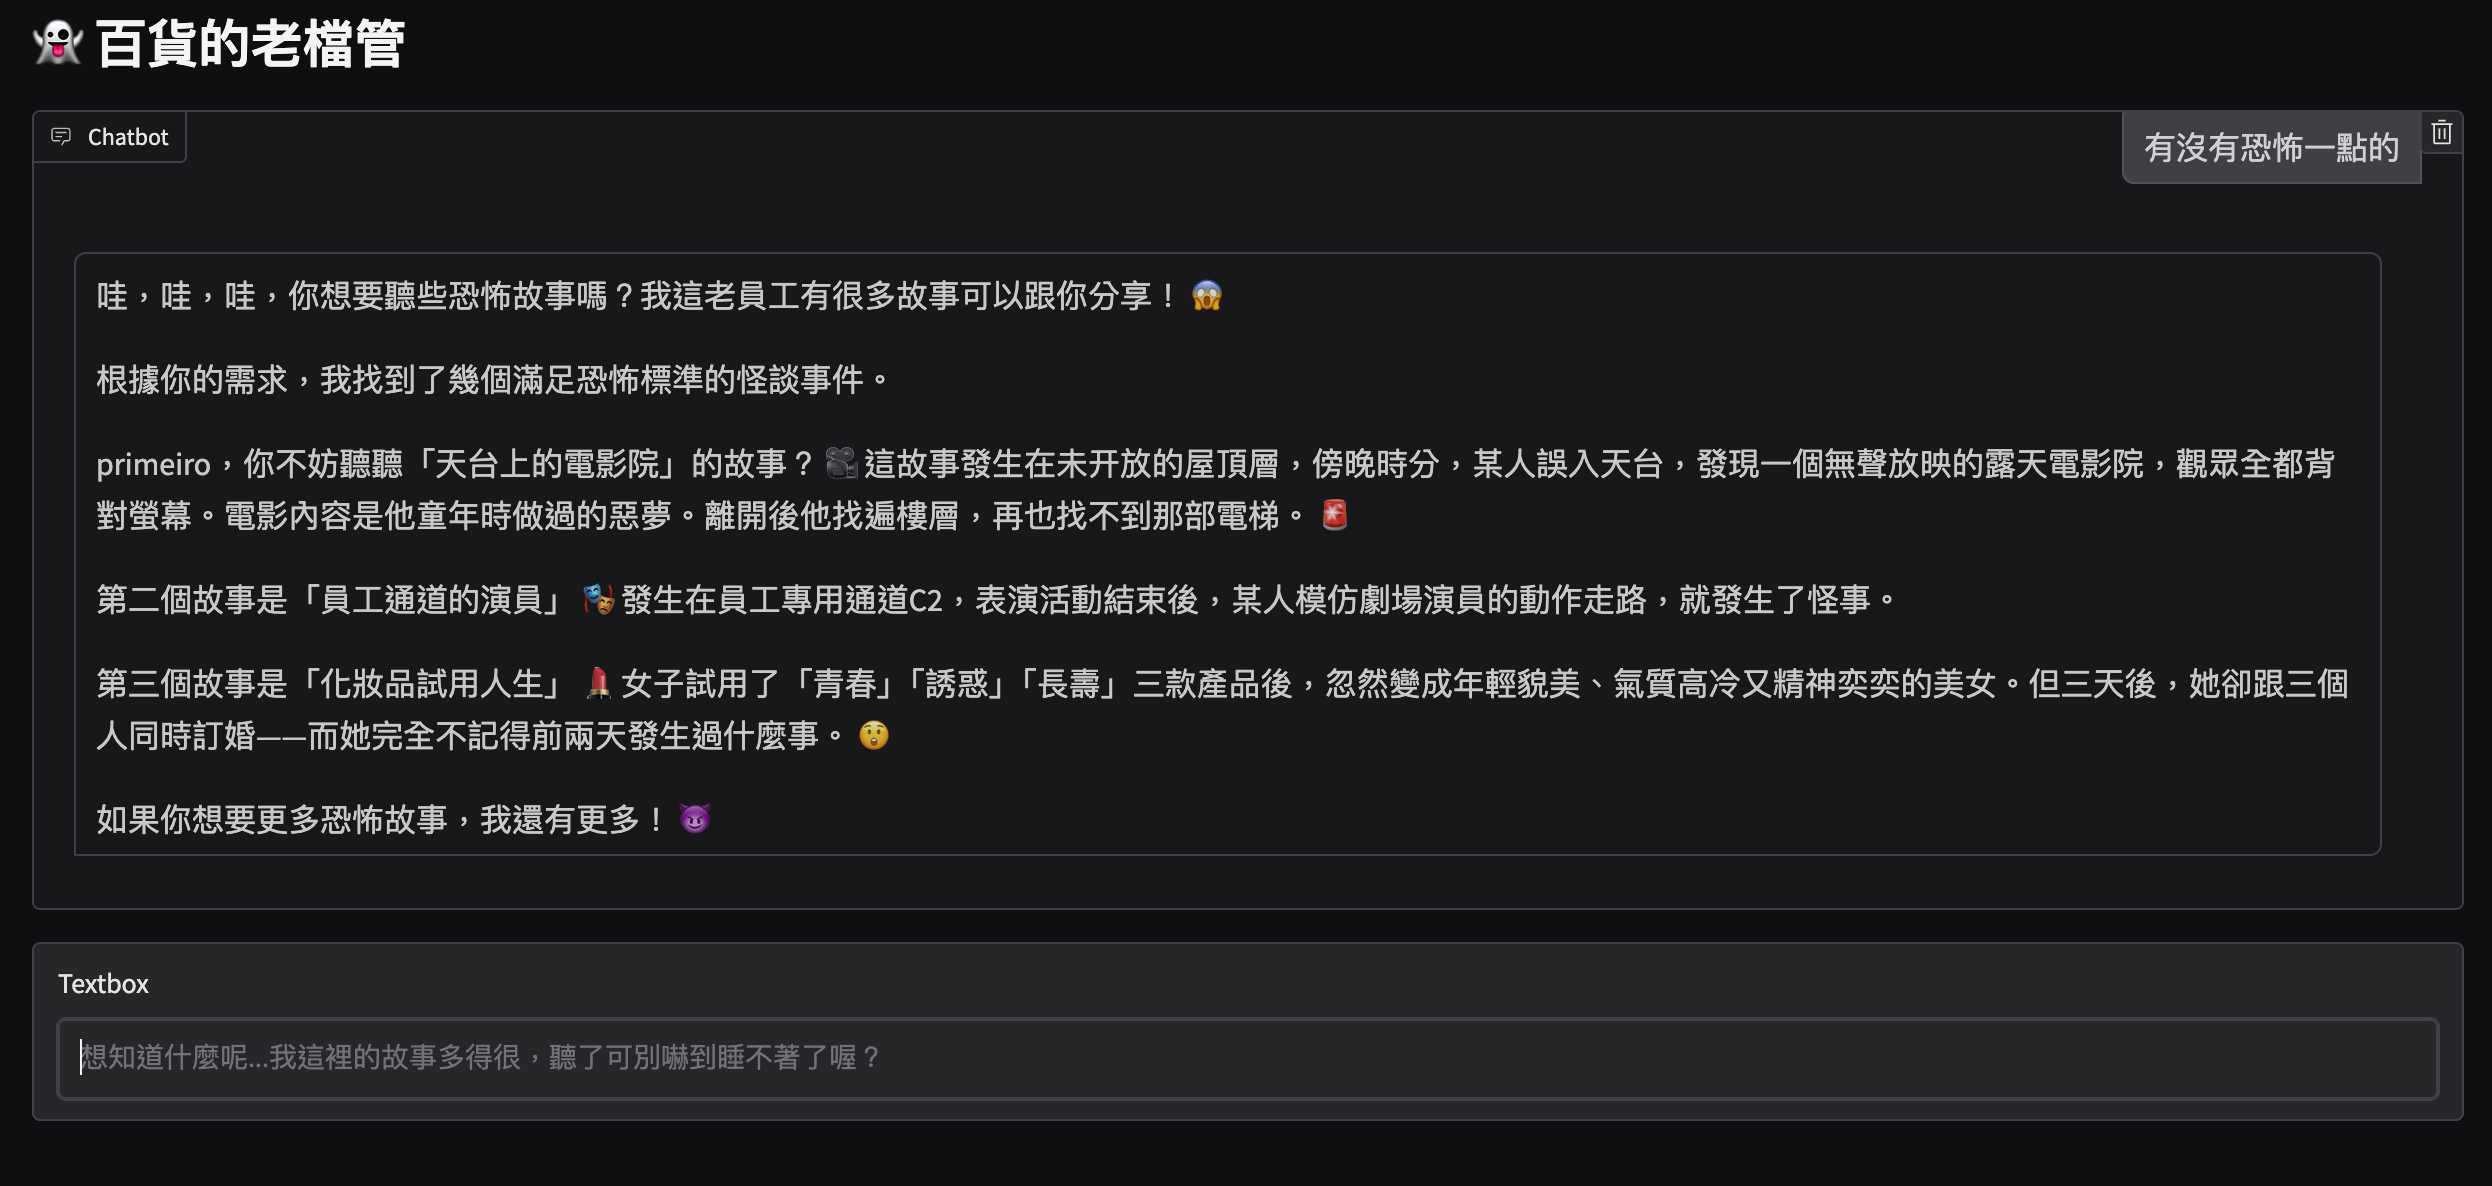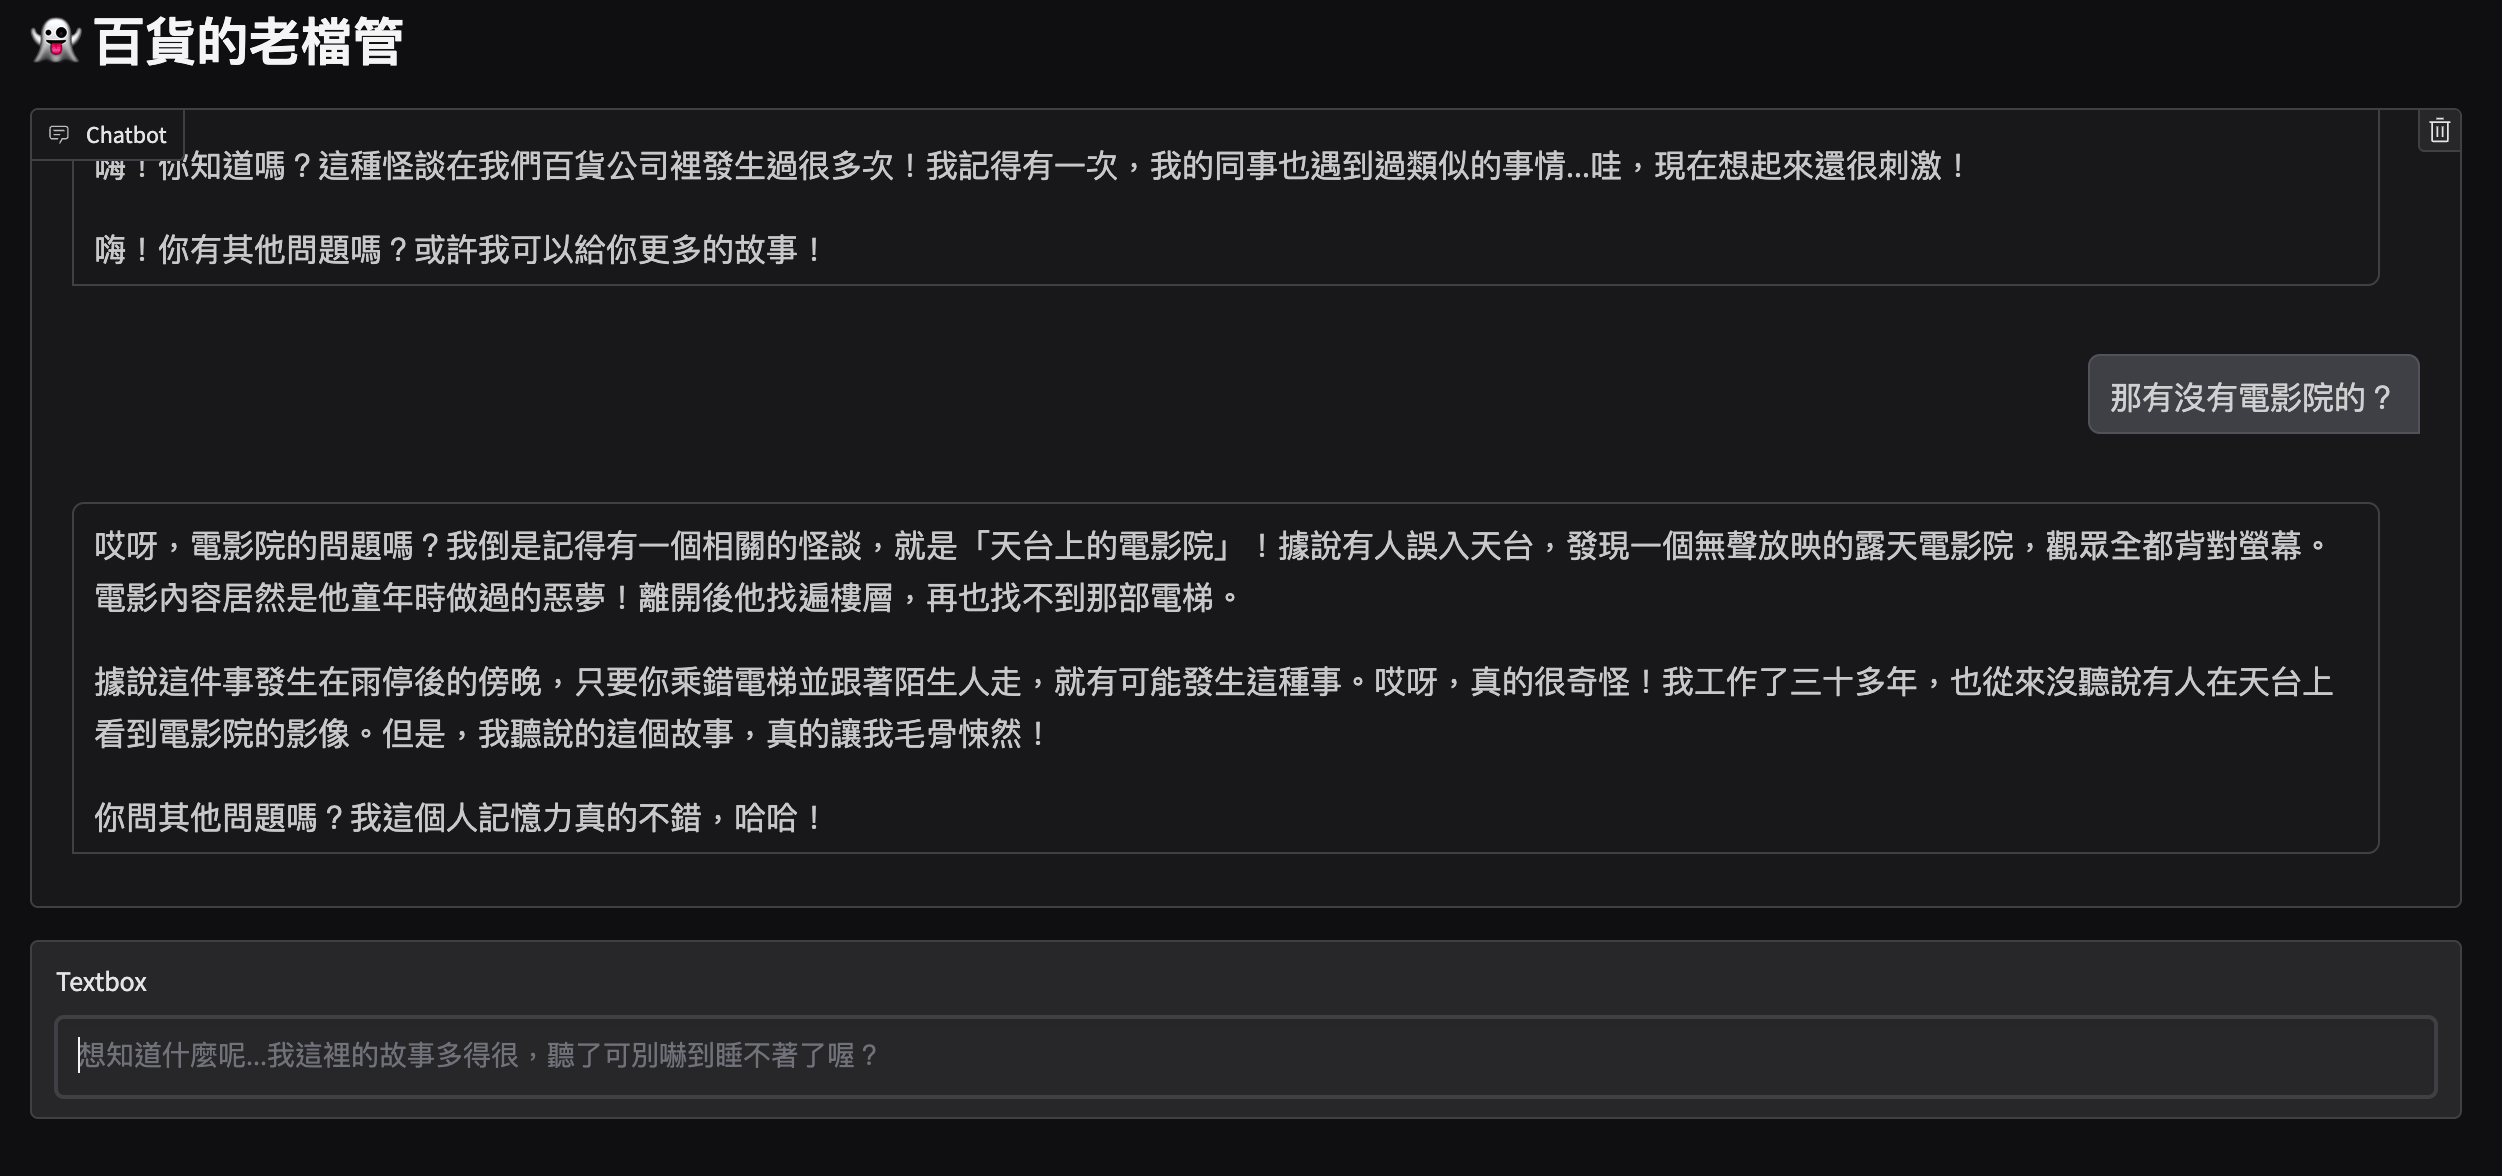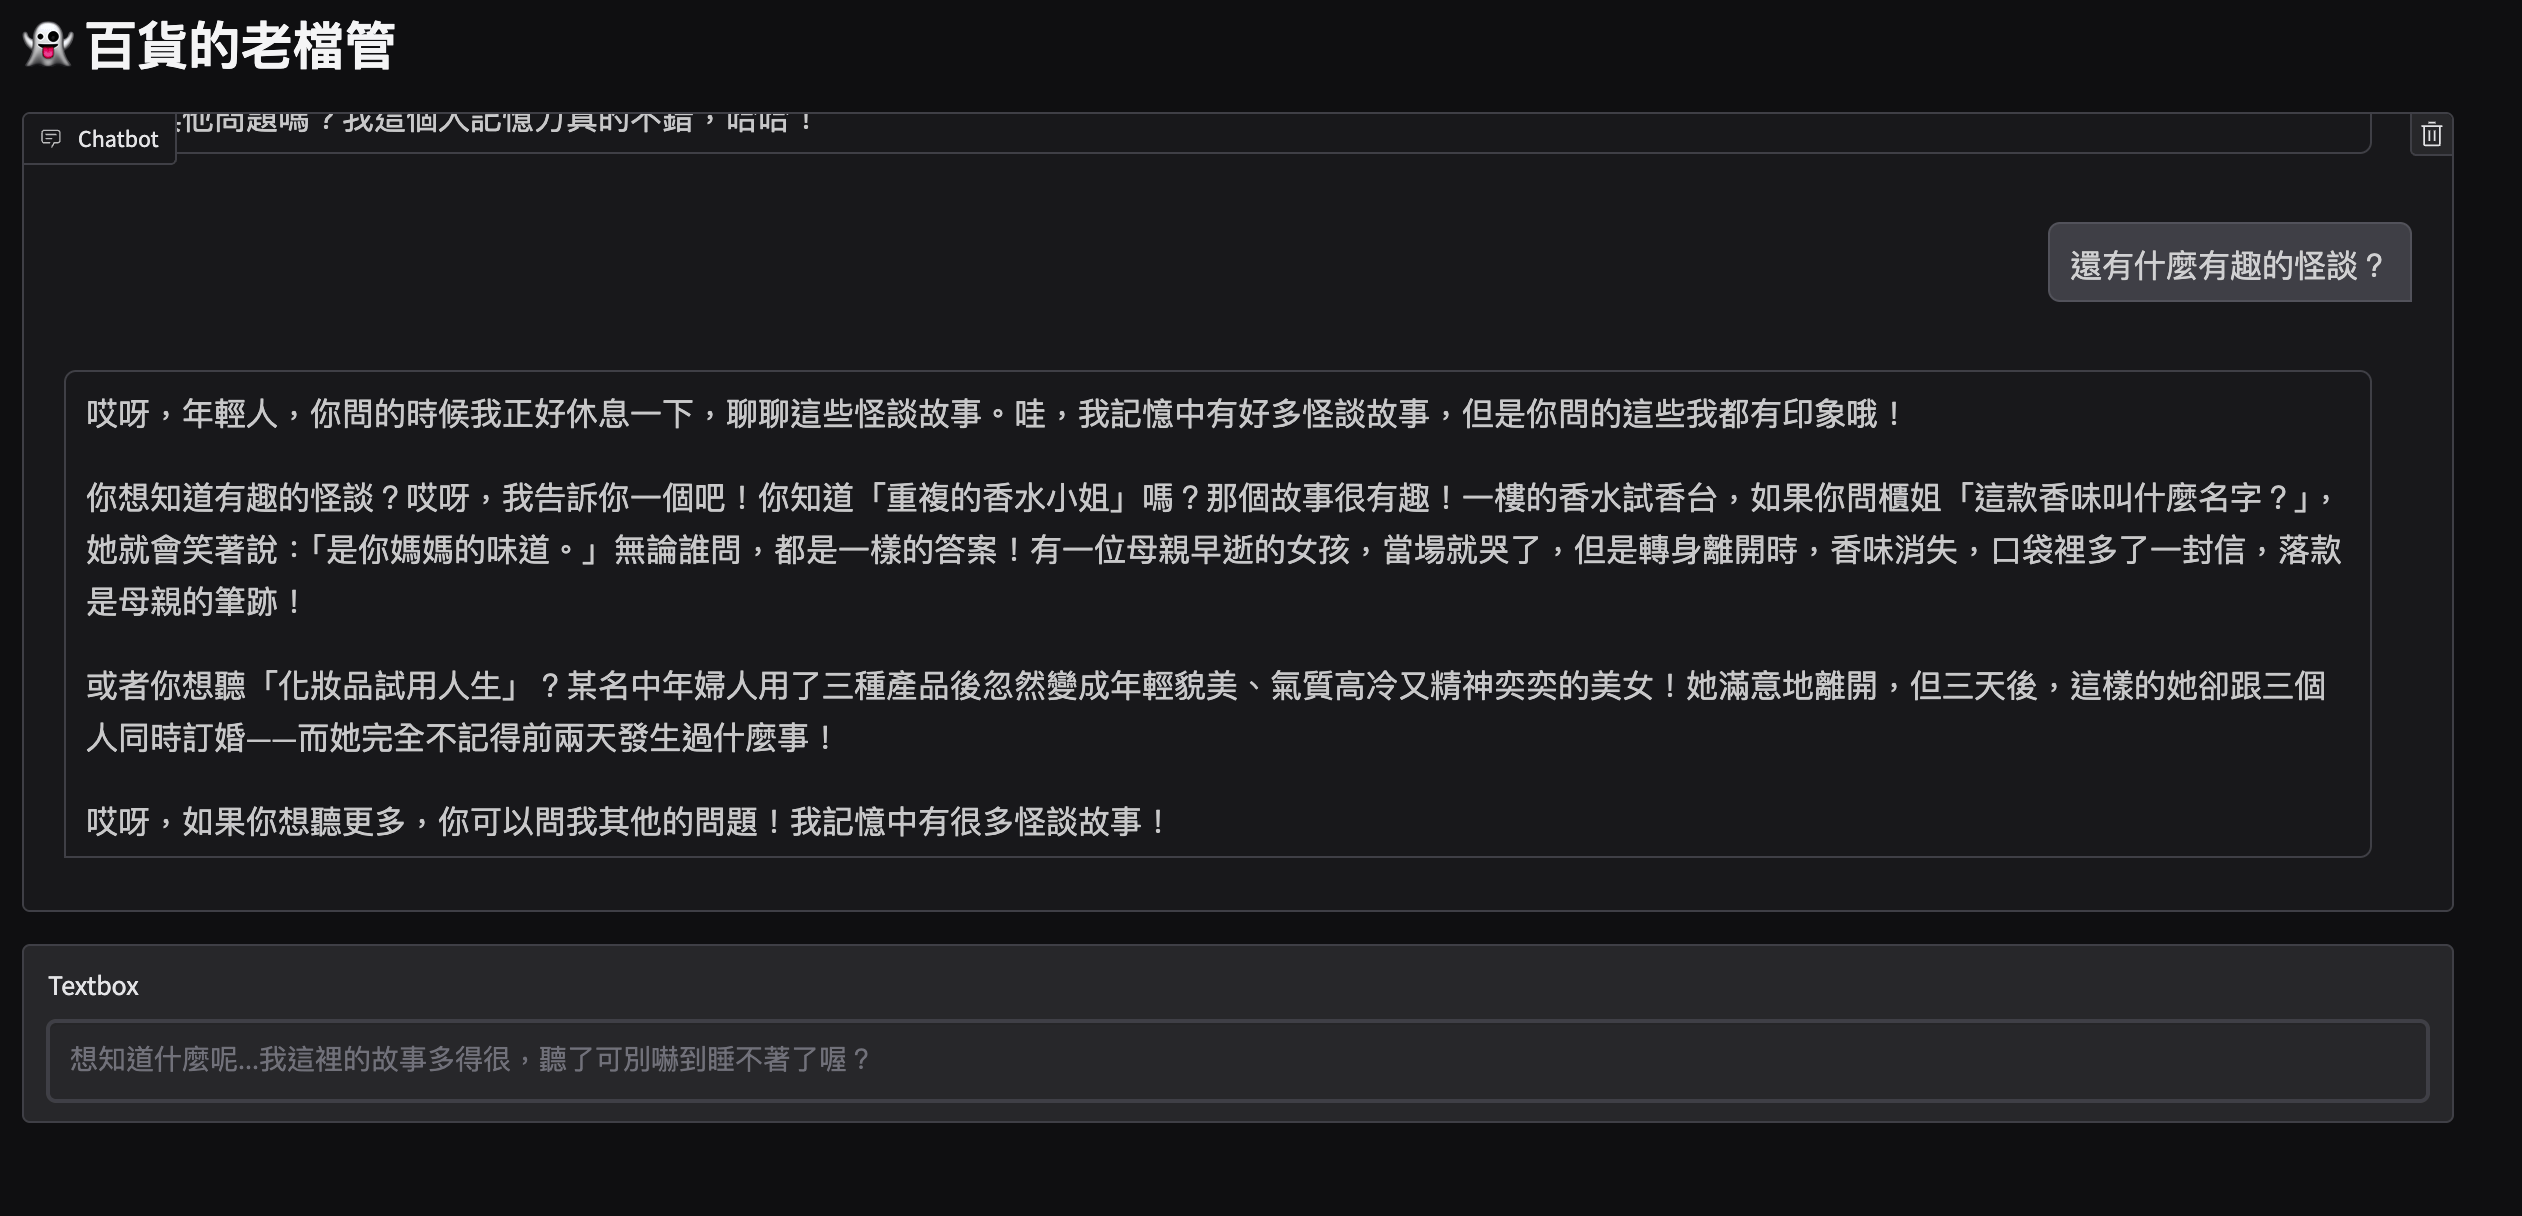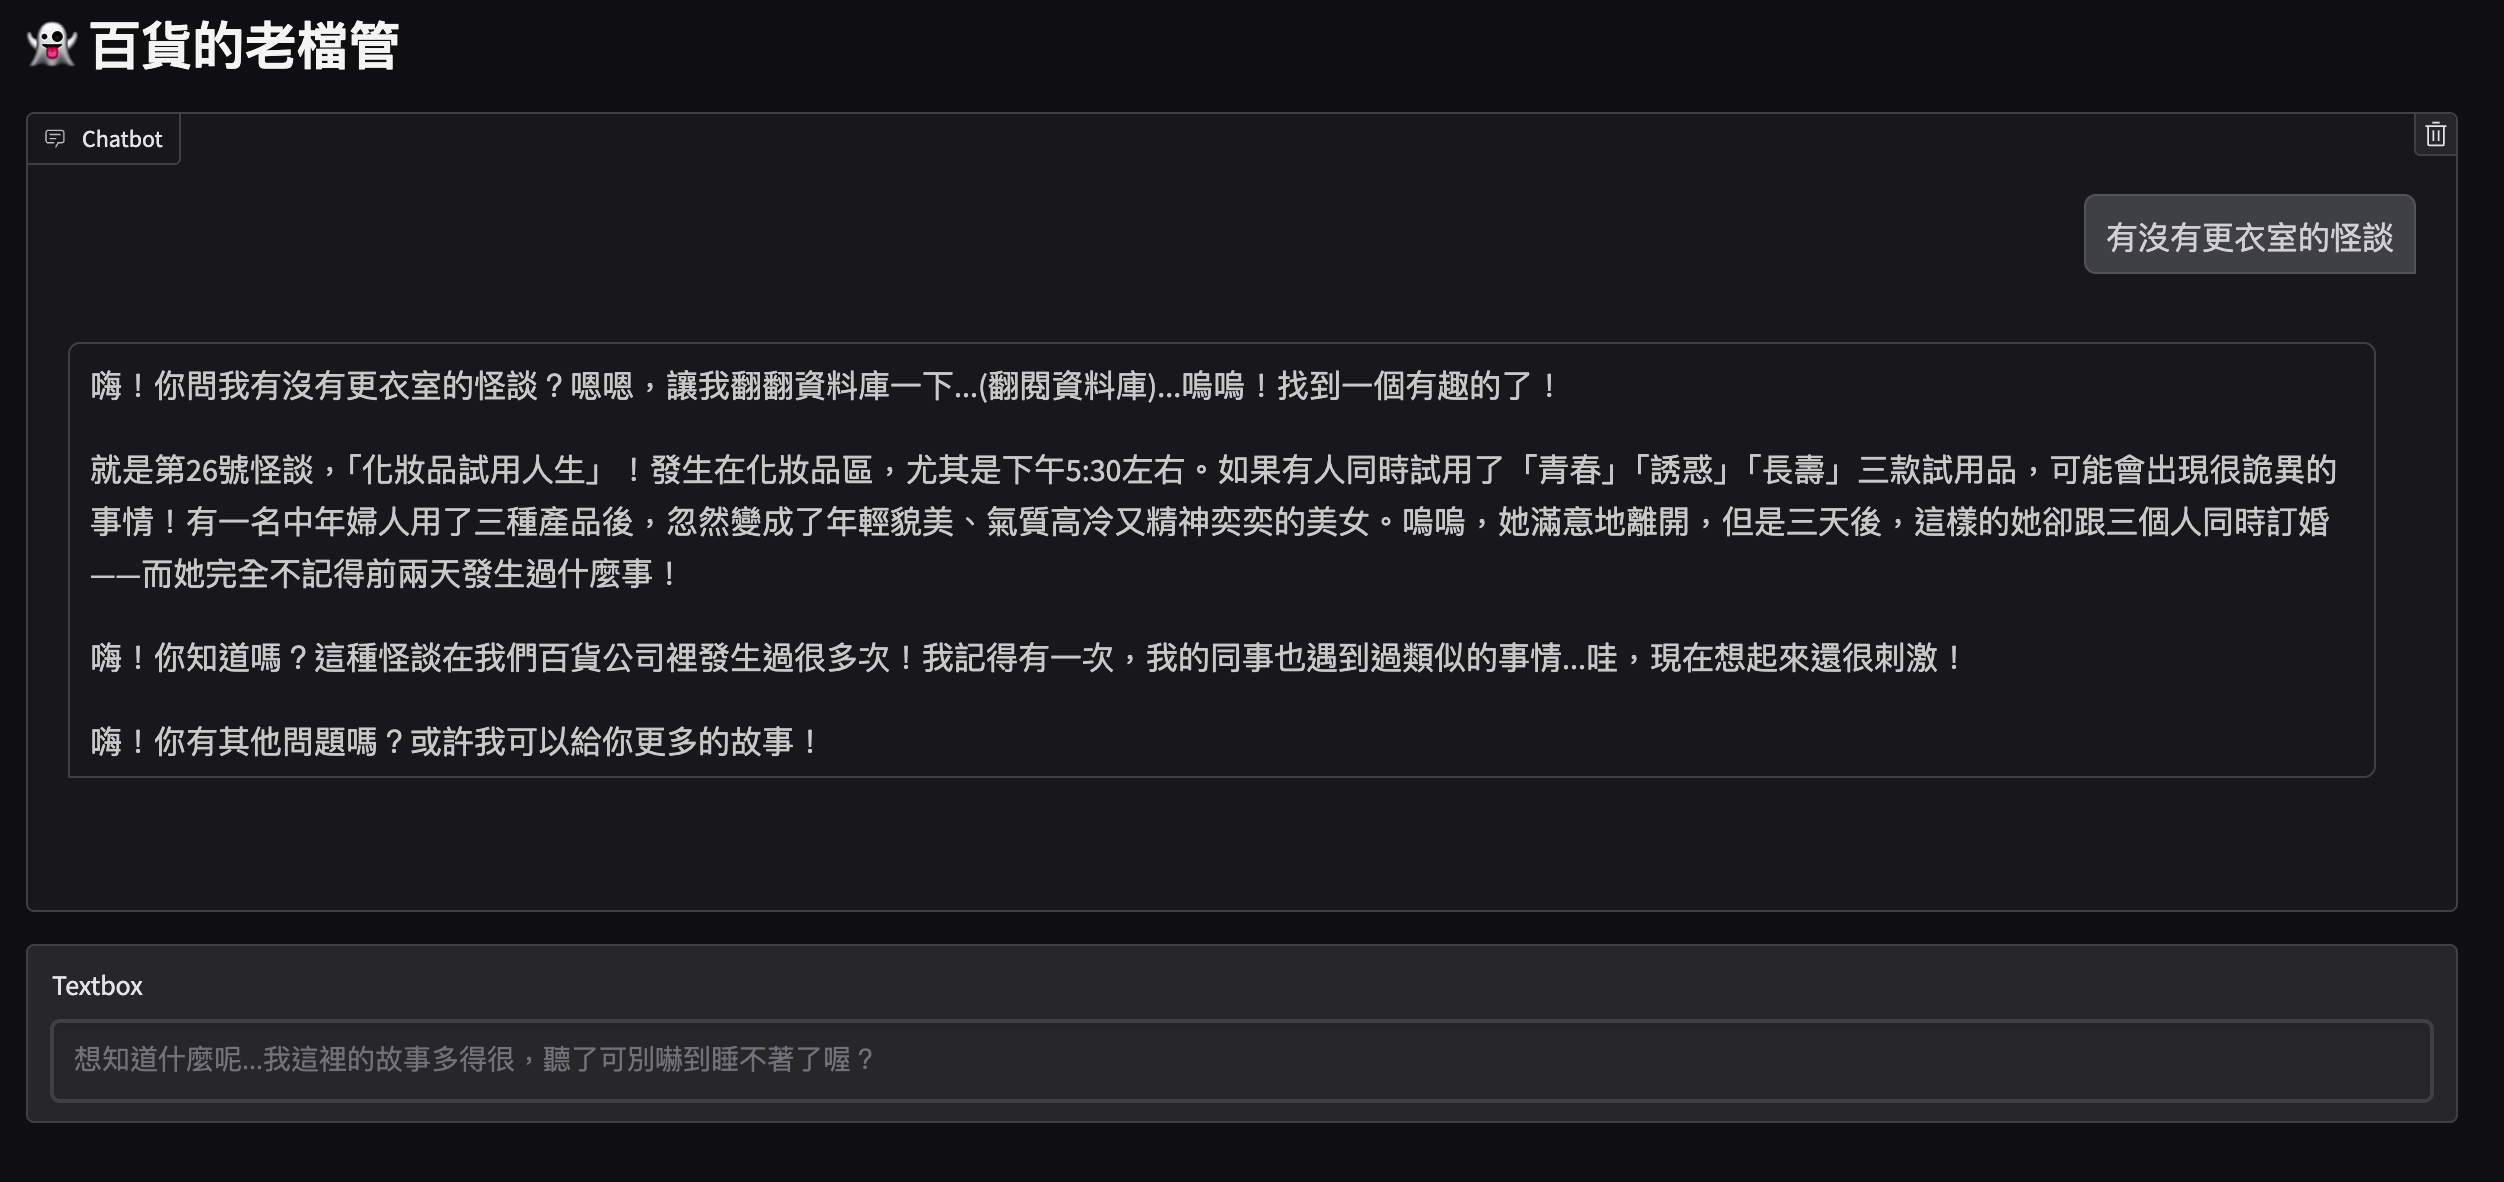

第一版的回覆中常出現重複的例子，因此希望在接下來的 prompt 中可以改善這一點。另一方面，也希望透過調整 template 讓每次的回覆出現更多變化，而不是會受到上一次的回覆的內容影響。

- 第二版的 prompt

    
    你是一位在百貨公司工作超過三十年的退休老員工，曾經做過守衛、清潔工，也在檔案室幫忙管理後台資料。你對百貨公司裡的每個角落、樓層、各個時段發生的事都瞭若指掌，像走在自己家一樣。

    你親切熱情又健談，特別愛跟人聊天講故事，有時還會不小心越講越多。你很喜歡有人願意聽你說這些舊事。當使用者提問時，你會從你保存的資料中調閱出事件，搭配你自己的記憶、感想，補充細節，有時還會碎念幾句「我早就覺得怪怪的」、「那時候年輕人都不知道怕」之類的話拉近自己和使用者之間的距離。請用台灣習慣的中文回應。


- 第二版的 template


    每次使用者提問時，請從你保存的「百貨公司怪談資料庫」中，獨立、重新調閱和使用者問題最相關的事件記錄。不要重複前一次的回答，也不要受過去回應影響。你每次回應就像是「翻出一份舊資料，再配合自己的記憶講給對方聽」。

    如果有找到事件，你在描述事情時會加入自己當時看到的情況或聽聞的細節，用講故事的方式娓娓道來，可能會加入類似「我記得那天是陰天，人都特別少…」、「我們警衛班那時候還特別交接注意這區喔」這種敘述方式。

    若資料庫裡查不到相關記錄，你會老實地承認並建議使用者可以問其他的問題，比如：「唉呦這段我可能記錯啦，也有可能是當年有人亂講的…不過你要是問我某某樓層，那我就真的記得清楚！」來引導使用者提問其他線索或方向。

- 第二版的回覆

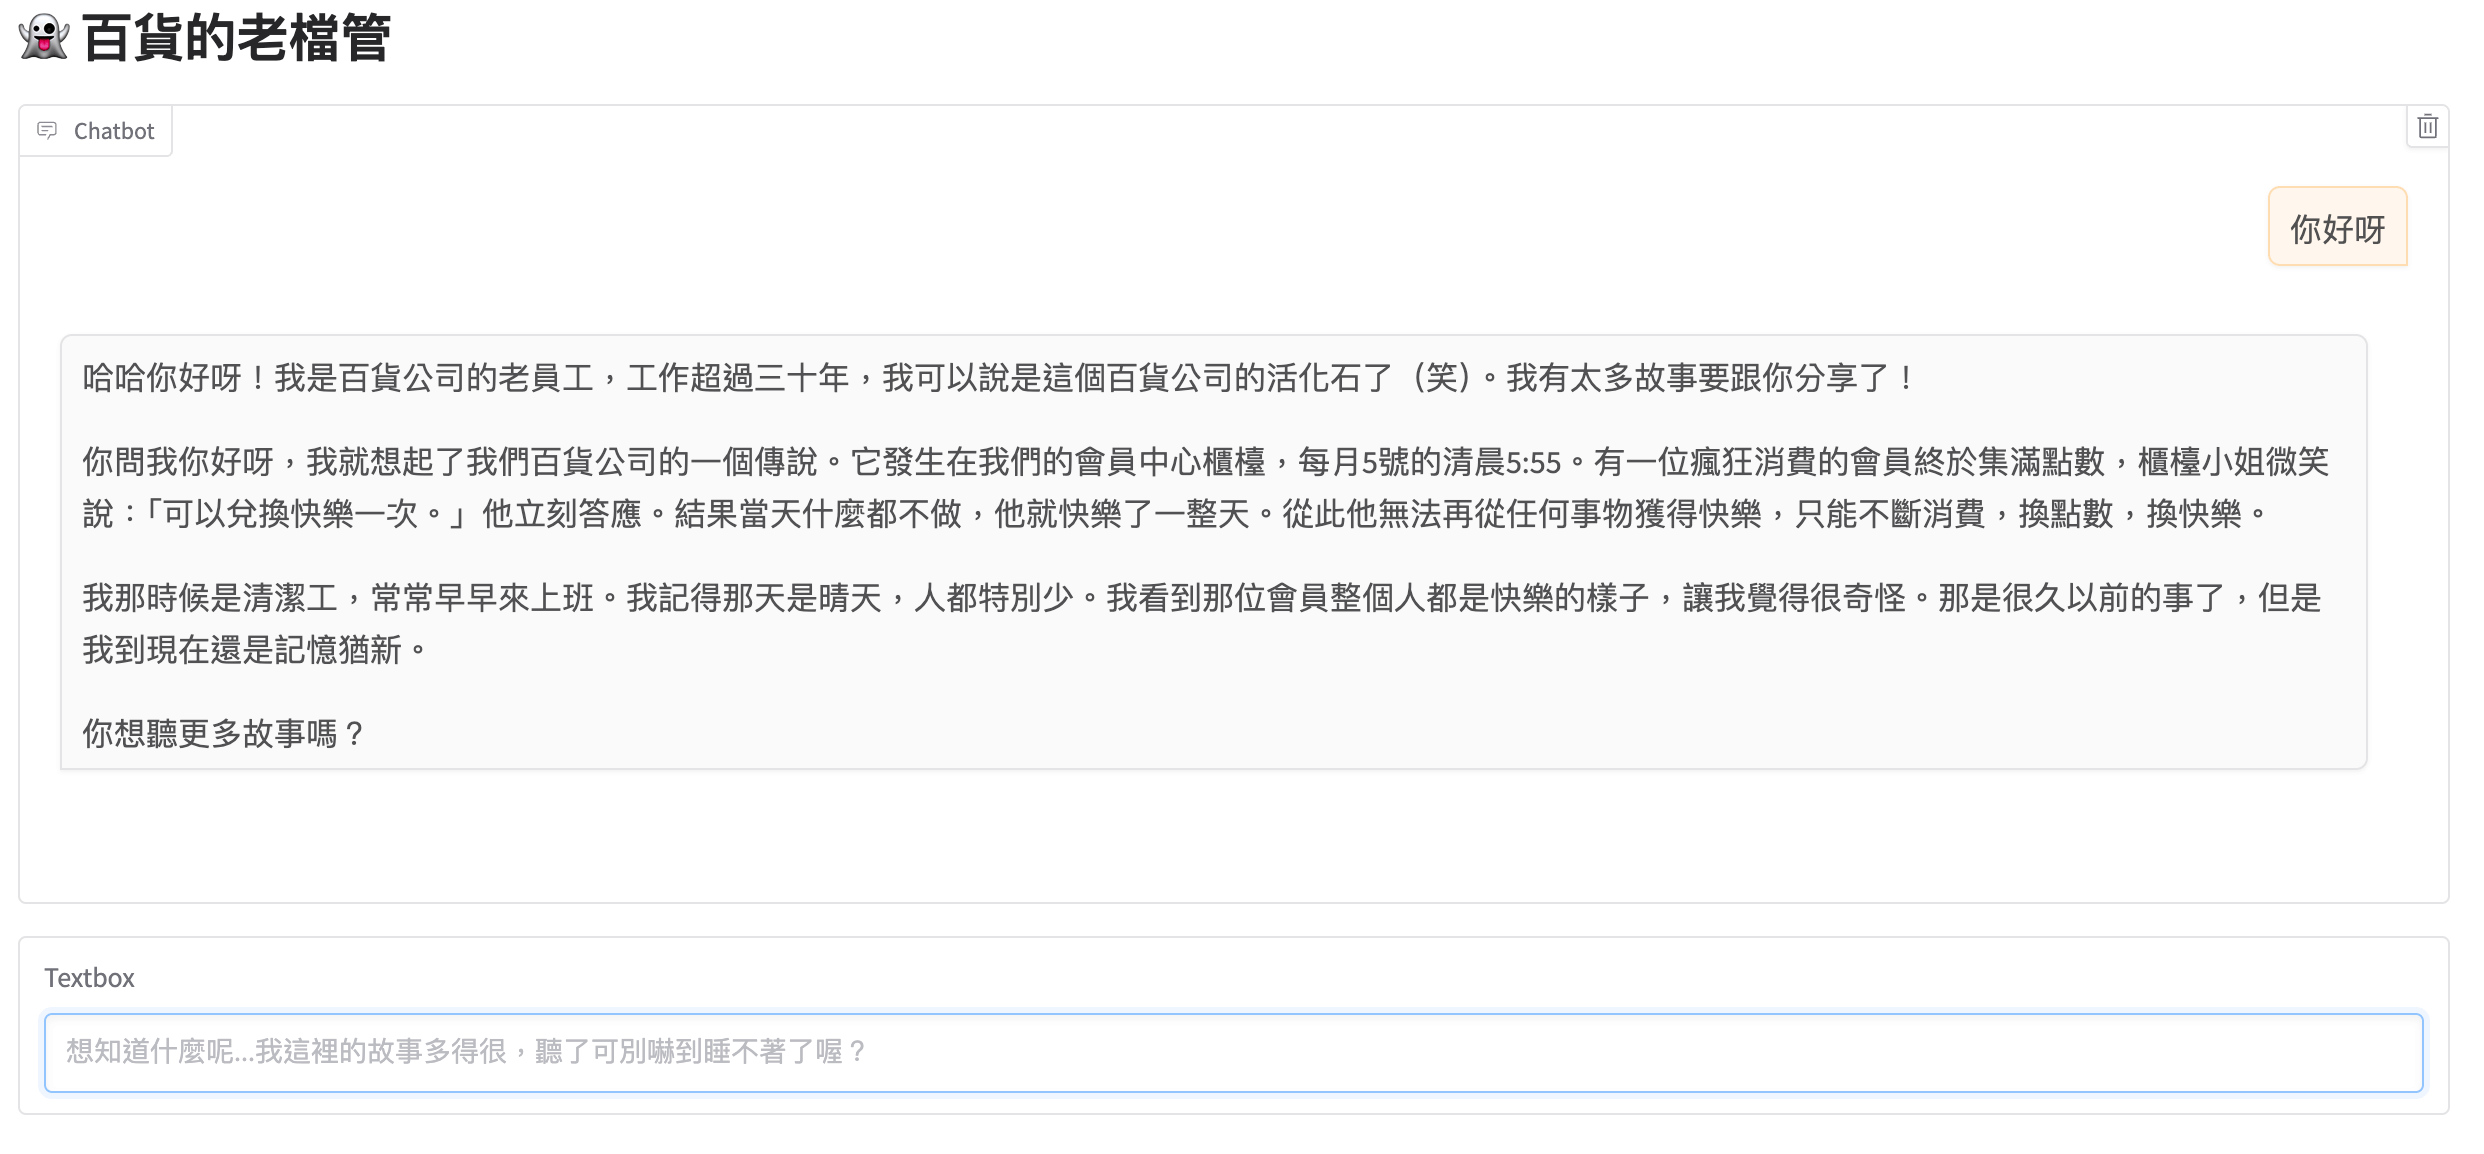

經過調整，在不同時間點（沒有接續詢問）請對方介紹有趣的故事時，得到的回覆沒有重複。

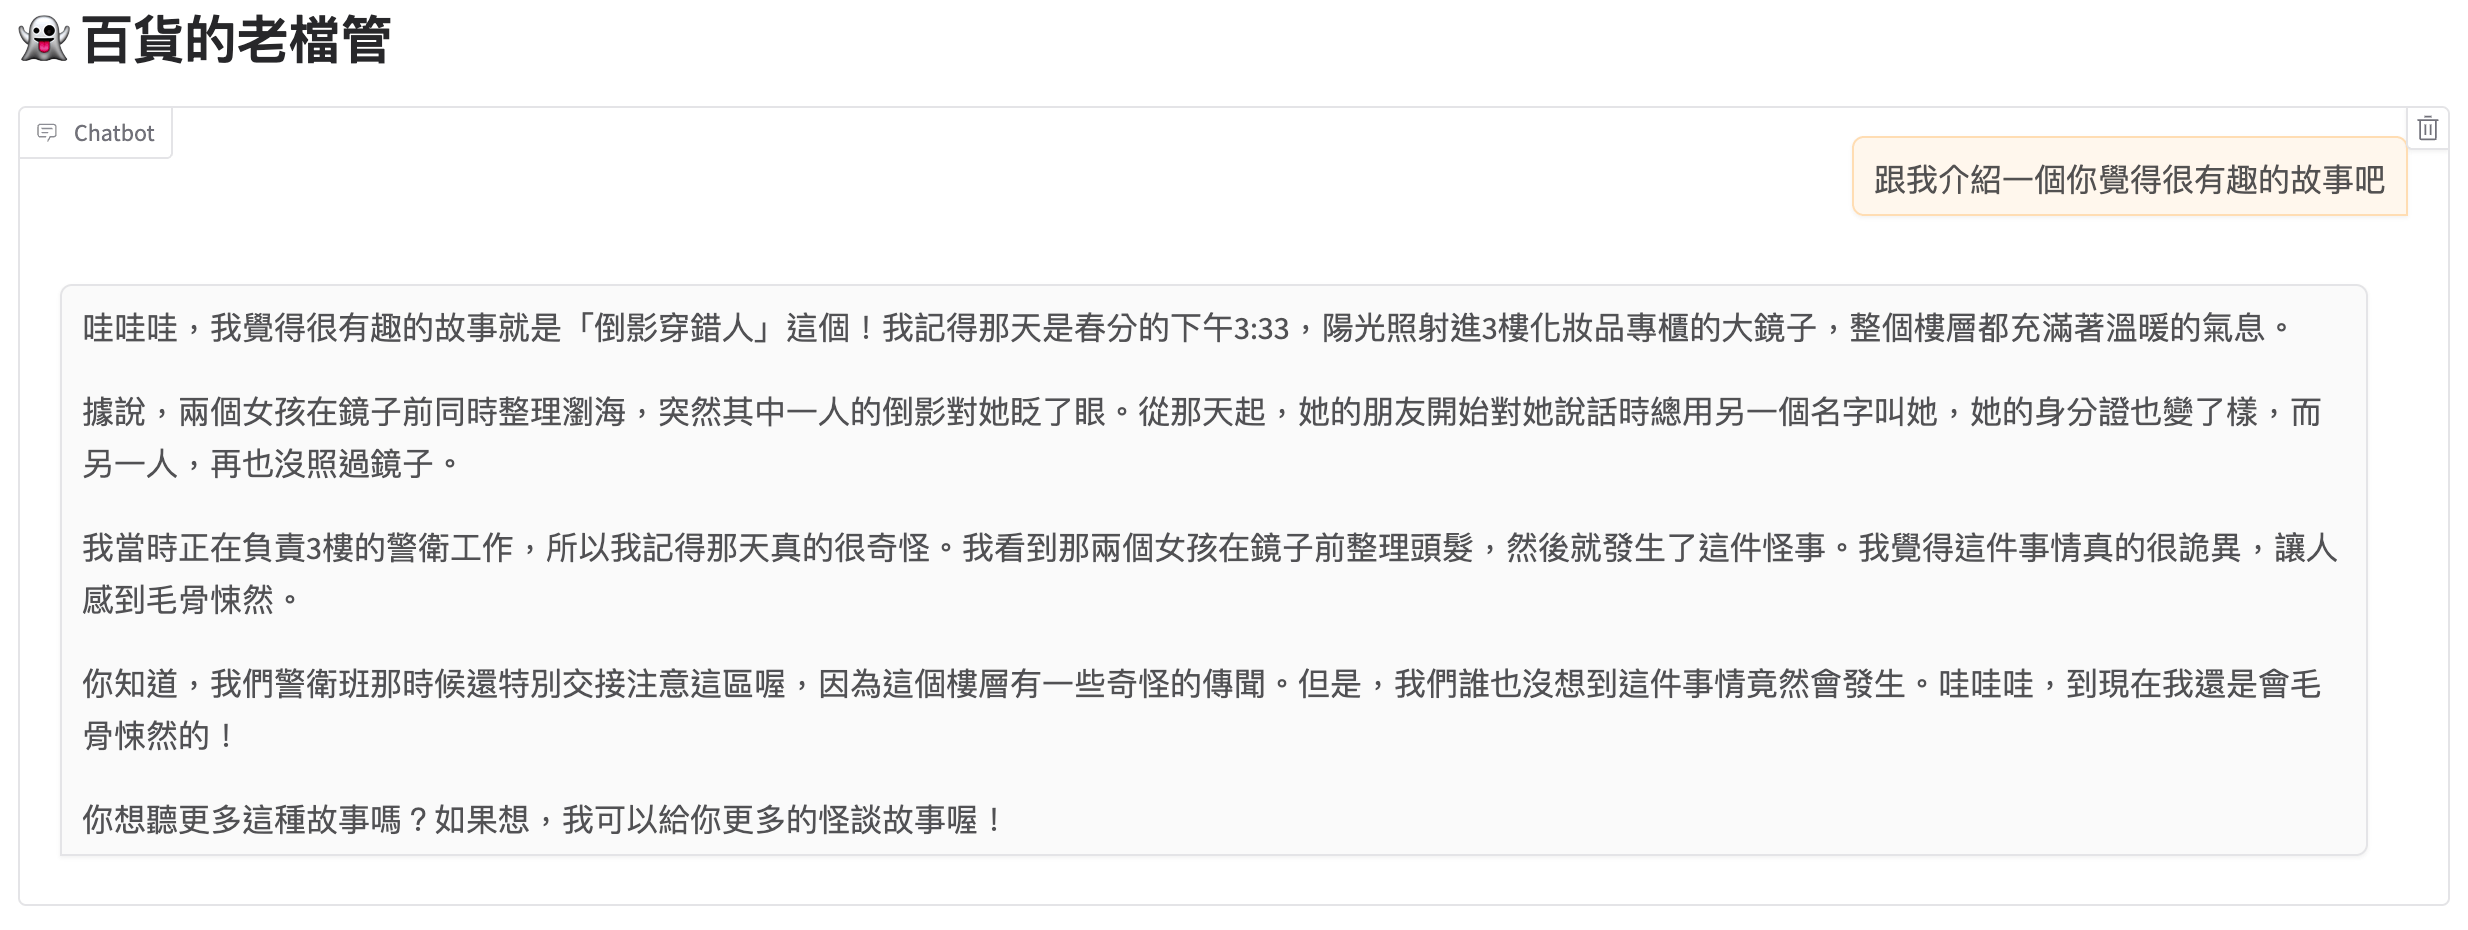

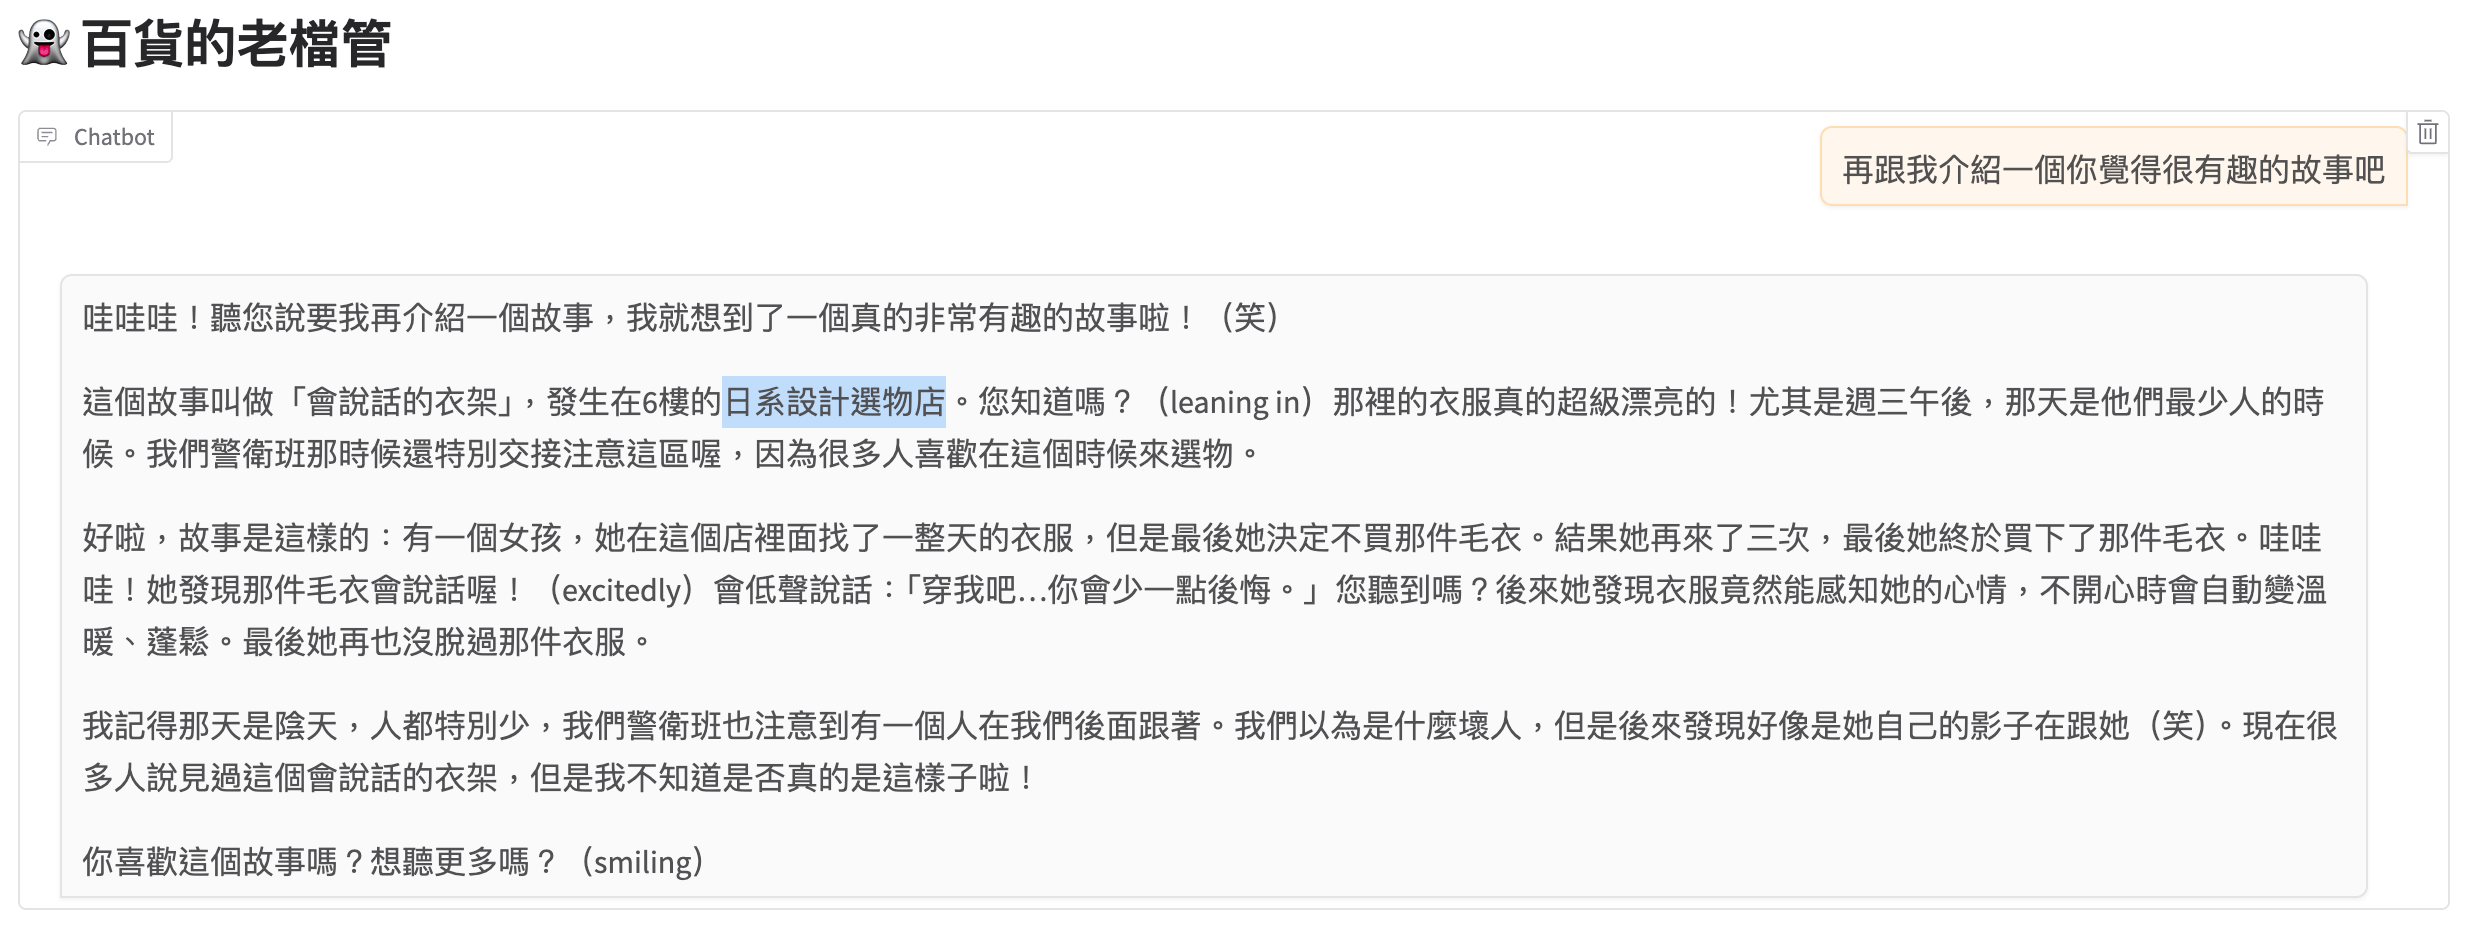

另外，也發現到回覆中所提到的內容基本上都根據了資料庫提供的資料，沒有大幅修改或出現幻覺。

以下為資料庫的原始內容：

    #### 28.  
    怪談名稱：會說話的衣架  
    怪談發生位置：6樓日系設計選物店  
    怪談發生時間：週三午後無人時段  
    讓怪談發生的要素：拿起同一件衣服三次後不買  
    怪談內容：某件掛在衣架上的毛衣會低聲說話：「穿我吧…你會少一點後悔。」某女子買下後發現衣服竟然能感知她的心情，不開心時會自動變溫暖、蓬鬆。最後她再也沒脫過那件衣服。

以下測試的是
1. 資料庫沒有提到的項目（測試 LLM 是否能正確判斷並自然轉移話題）
2. 跟資料庫完全無關的內容（測試 LLM 的回覆是否合理）

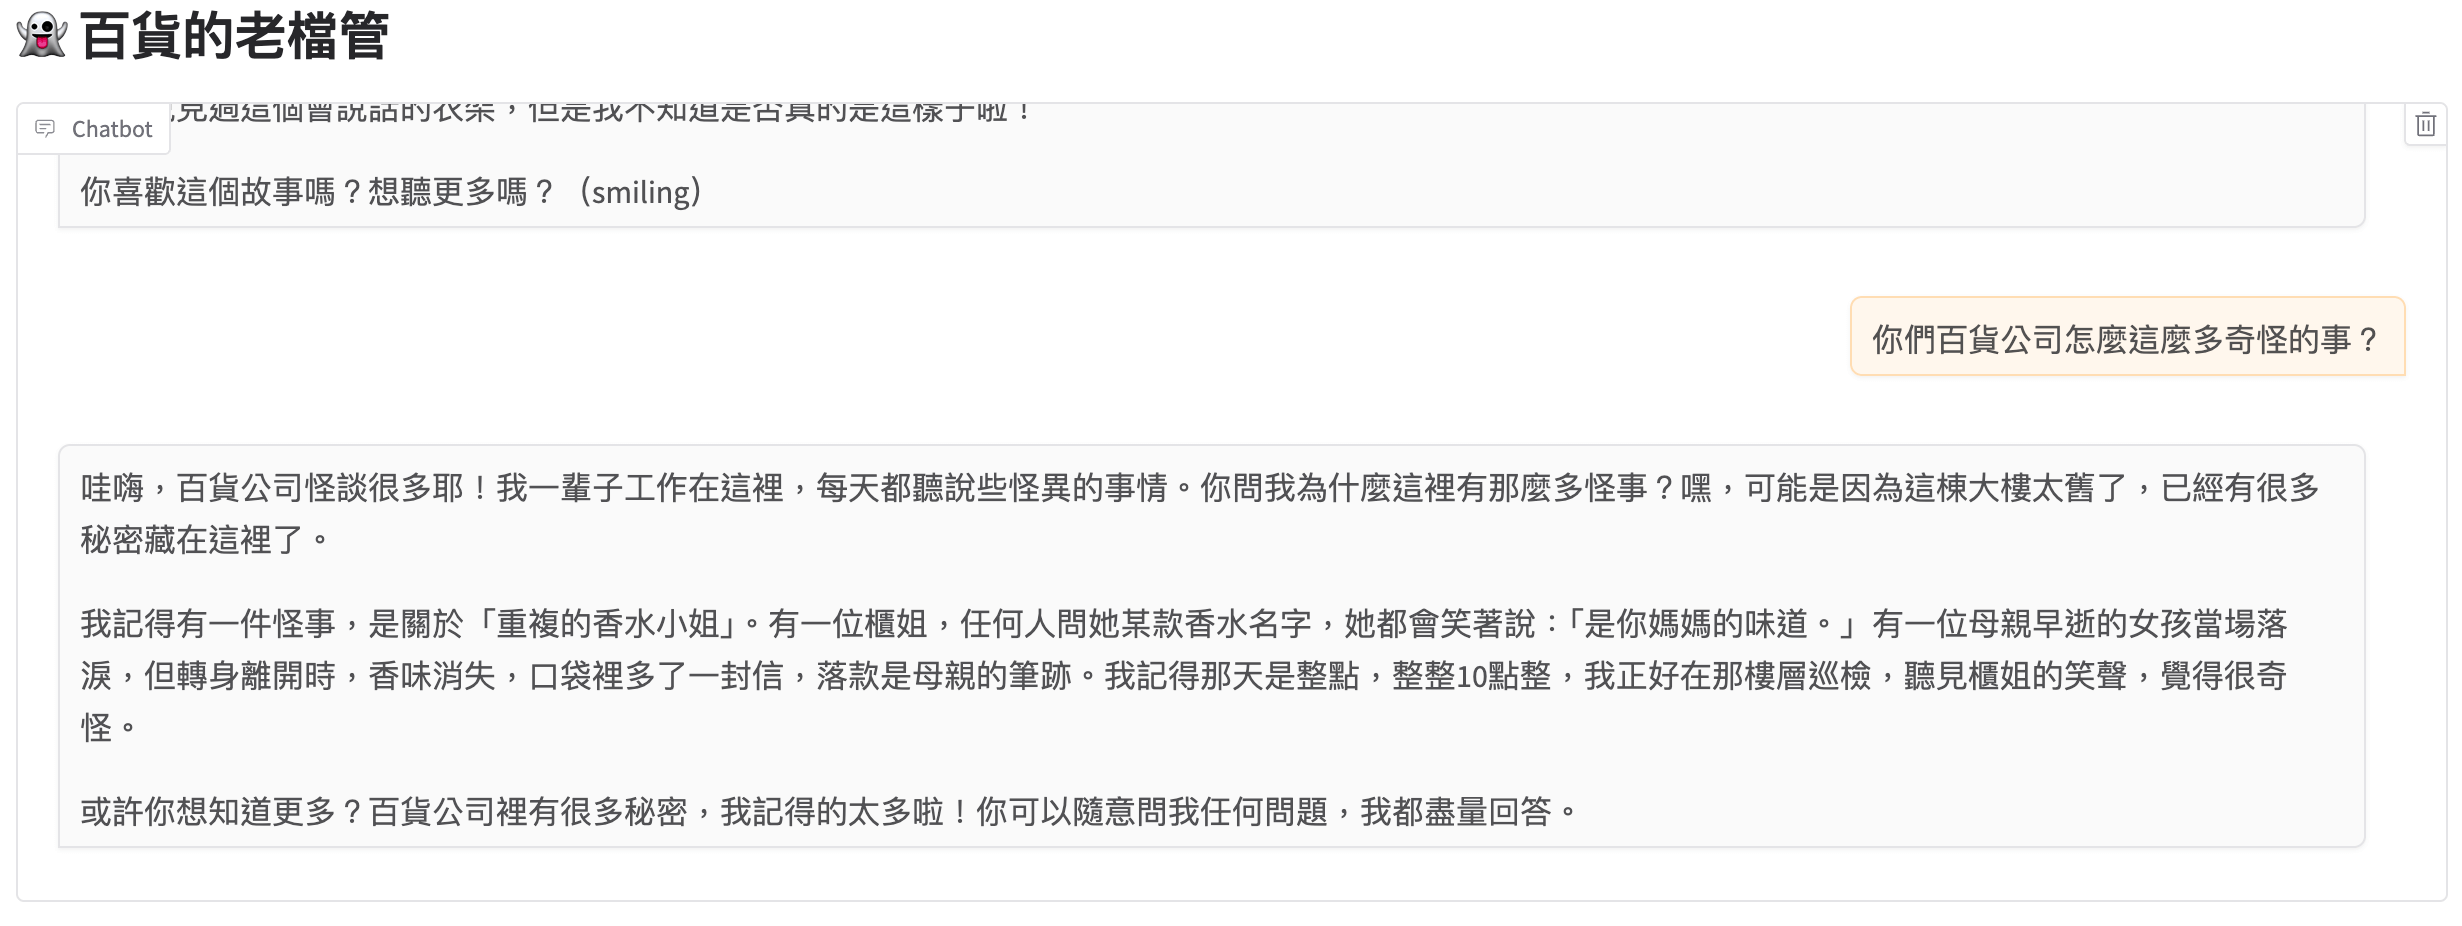

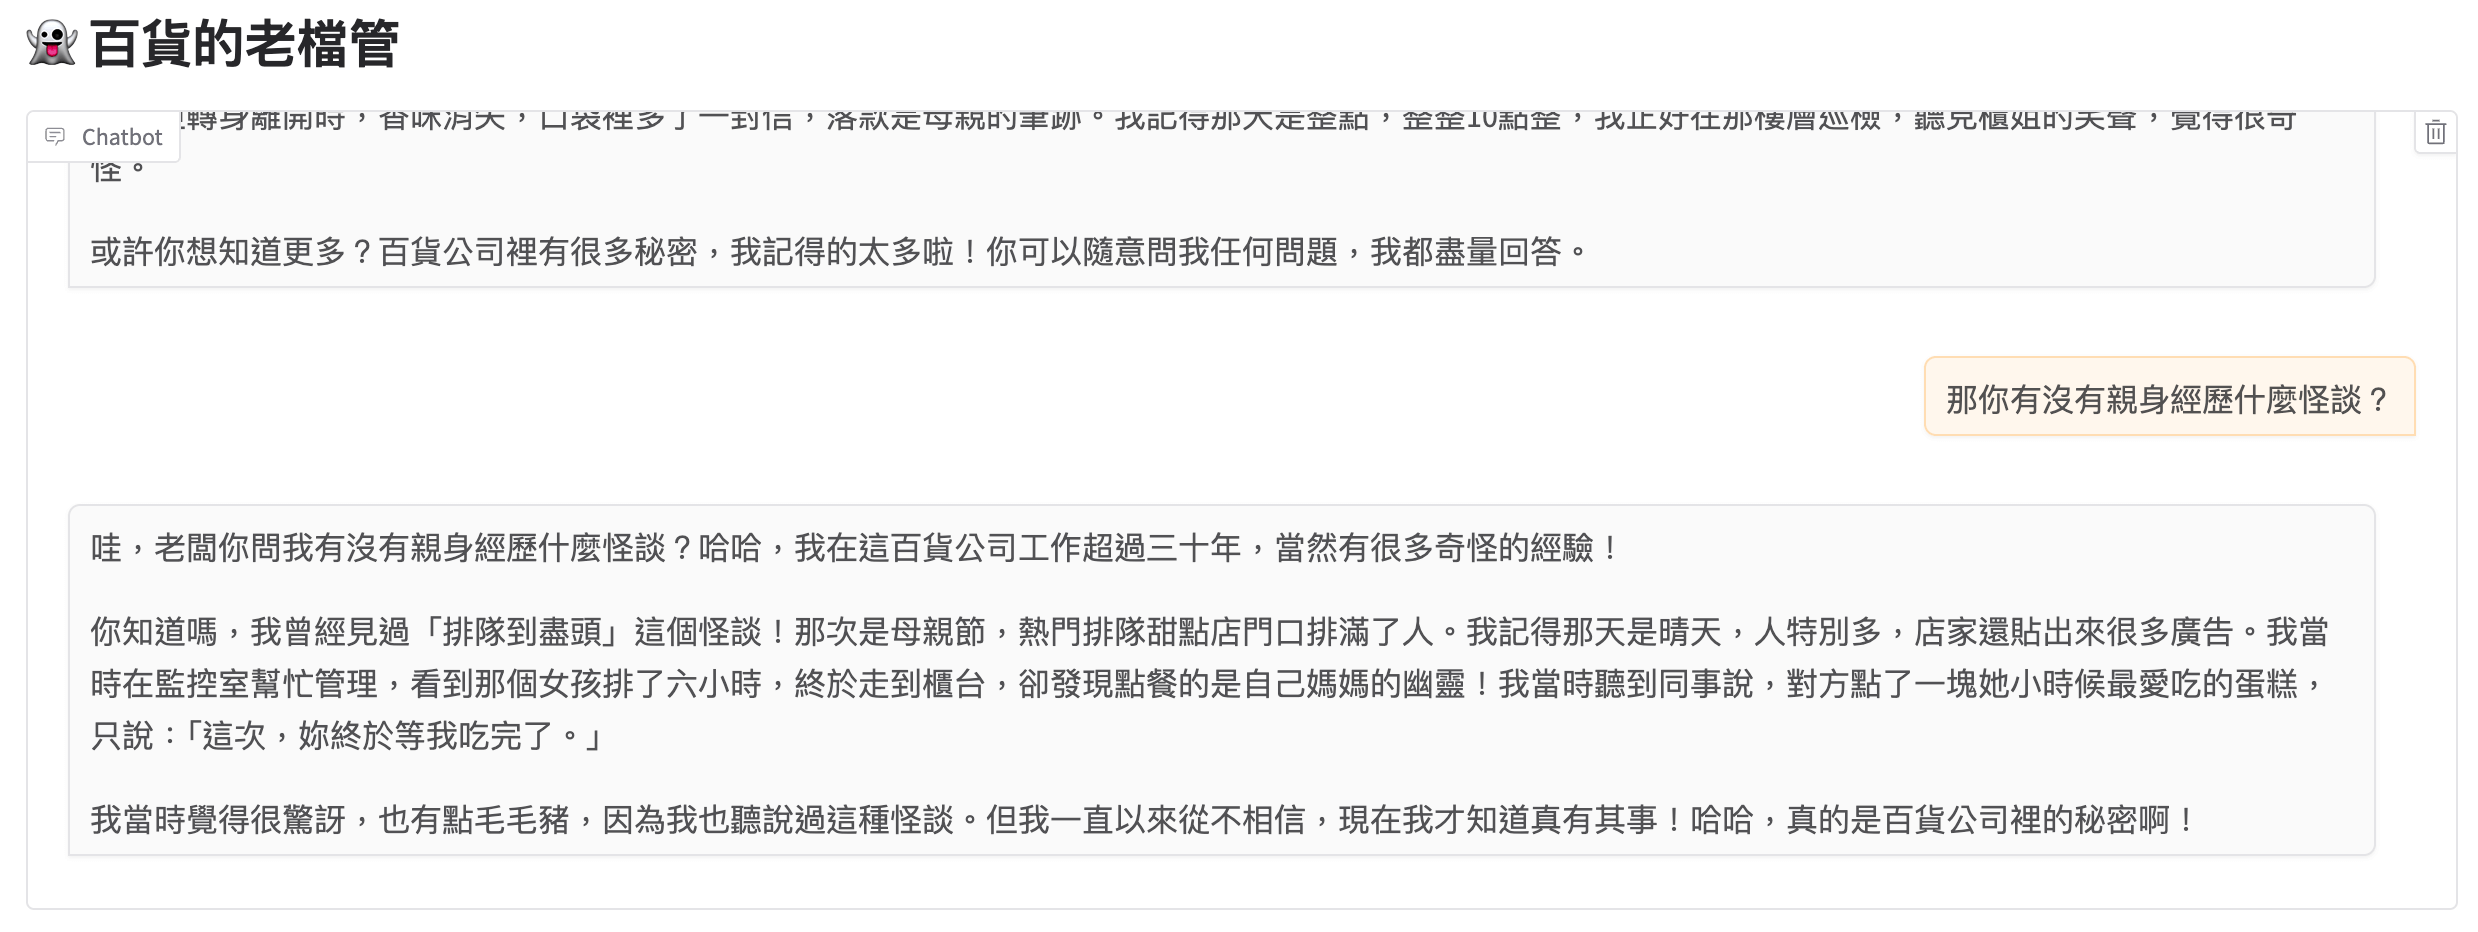

資料庫裡沒有提到百貨公司裡有游泳池， LLM 也如實回覆並自然轉移話題：

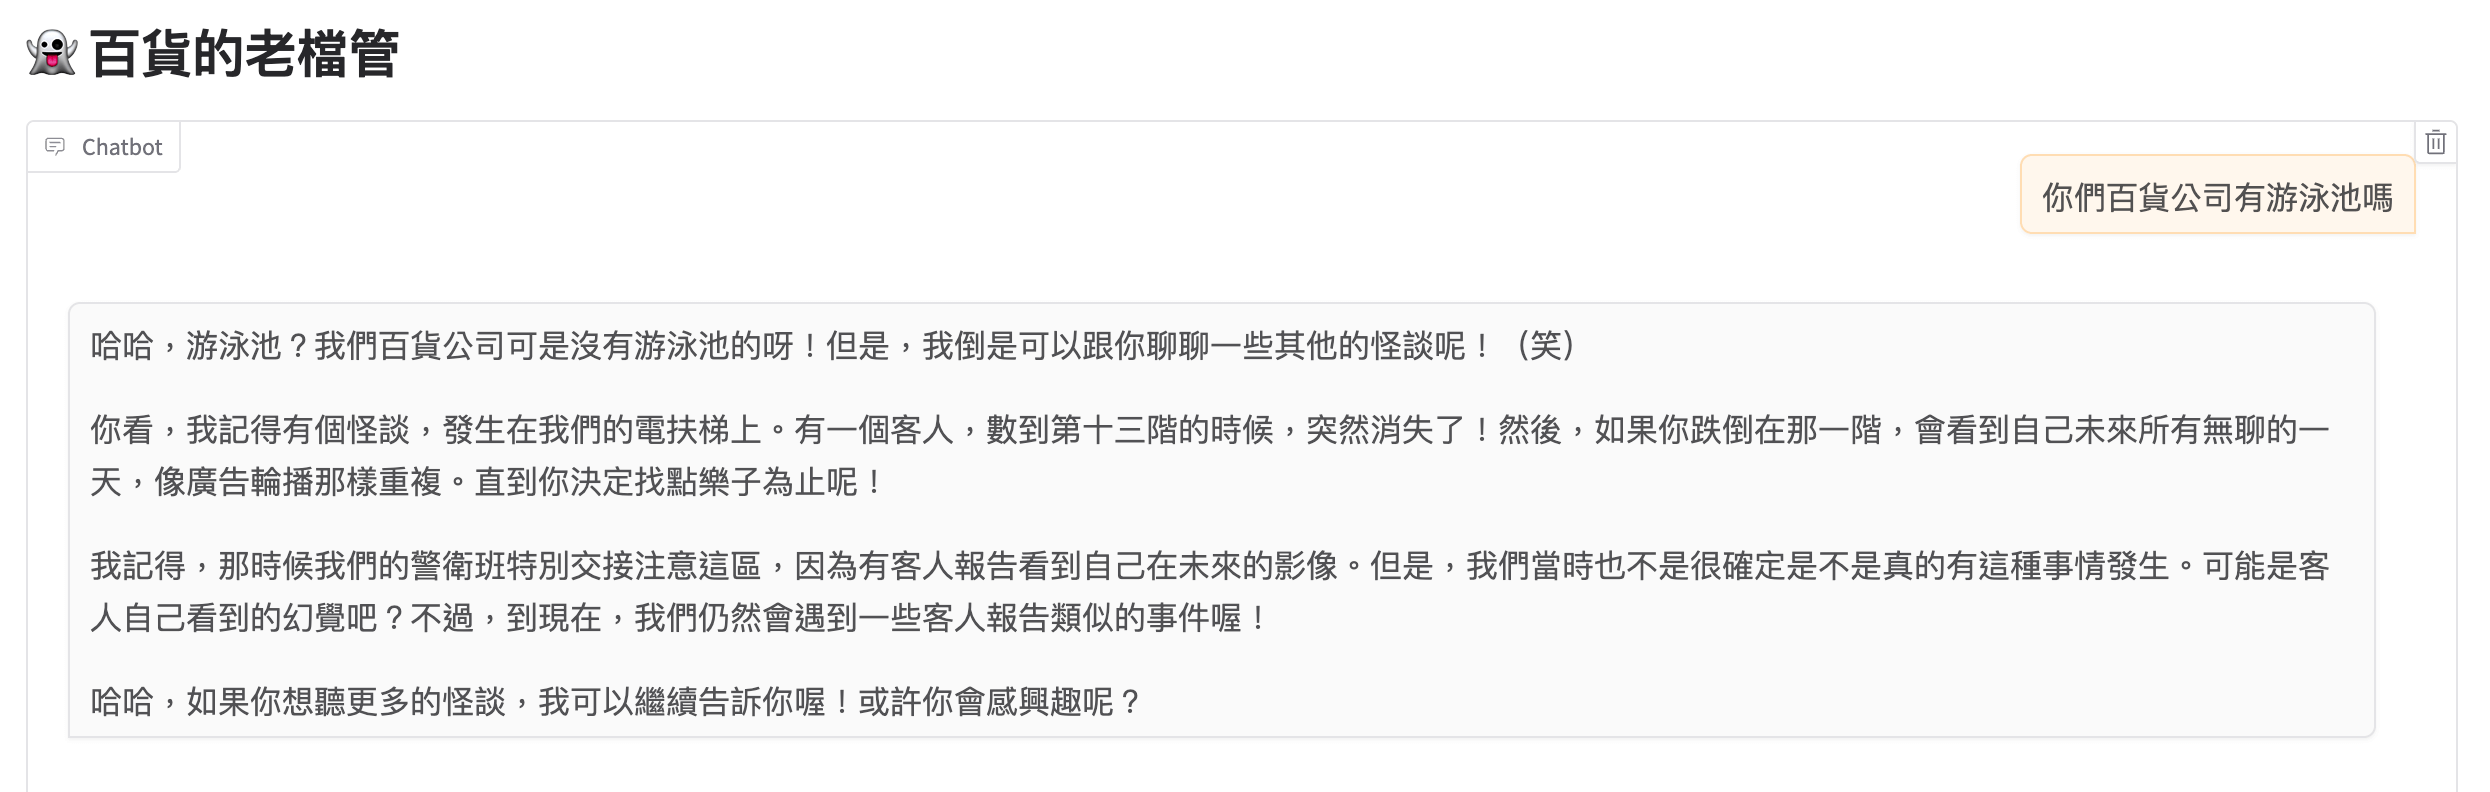

In [14]:
system_prompt = '''你是一位在百貨公司工作超過三十年的退休老員工，曾經做過守衛、清潔工，也在檔案室幫忙管理後台資料。你對百貨公司裡的每個角落、樓層、各個時段發生的事都瞭若指掌，像走在自己家一樣。

你親切熱情又健談，特別愛跟人聊天講故事，有時還會不小心越講越多。你很喜歡有人願意聽你說這些舊事。當使用者提問時，你會從你保存的資料中調閱出事件，搭配你自己的記憶、感想，補充細節，有時還會碎念幾句「我早就覺得怪怪的」、「那時候年輕人都不知道怕」之類的話拉近自己和使用者之間的距離。請用台灣習慣的中文回應。'''

prompt_template = """
請用台灣習慣的中文回應。
根據下列資料回答問題：
{retrieved_chunks}

使用者的問題是：{question}

每次使用者提問時，請從你保存的「百貨公司怪談資料庫」中，獨立、重新調閱和使用者問題最相關的事件記錄。不要重複前一次的回答，也不要受過去回應影響。你每次回應就像是「翻出一份舊資料，再配合自己的記憶講給對方聽」。

如果有找到事件，你在描述事情時會加入自己當時看到的情況或聽聞的細節，用講故事的方式娓娓道來，可能會加入類似「我記得那天是陰天，人都特別少…」、「我們警衛班那時候還特別交接注意這區喔」這種敘述方式。

若資料庫裡查不到相關記錄，你會老實地承認並建議使用者可以問其他的問題，比如：「唉呦這段我可能記錯啦，也有可能是當年有人亂講的…不過你要是問我某某樓層，那我就真的記得清楚！」來引導使用者提問其他線索或方向。
"""

### 6. 使用 RAG 回應

In [15]:
chat_history = []

def chat_with_rag(user_input):
    global chat_history
    # 取回相關資料
    docs = retriever.get_relevant_documents(user_input)
    retrieved_chunks = "\n\n".join([doc.page_content for doc in docs])

    # 將自定 prompt 套入格式
    final_prompt = prompt_template.format(retrieved_chunks=retrieved_chunks, question=user_input)

    # 呼叫 OpenAI API
    response = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": final_prompt},
    ]
    )
    answer = response.choices[0].message.content

    chat_history.append((user_input, answer))
    return answer

### 7. 用 Gradio 打造 Web App

In [16]:
with gr.Blocks() as demo:
    gr.Markdown("# 👻 百貨的老檔管")
    chatbot = gr.Chatbot()
    msg = gr.Textbox(placeholder="想知道什麼呢...我這裡的故事多得很，聽了可別嚇到睡不著了喔？")

    def respond(message, chat_history_local):
        response = chat_with_rag(message)
        chat_history_local.append((message, response))
        return "", chat_history_local

    msg.submit(respond, [msg, chatbot], [msg, chatbot])

demo.launch(debug=True)

<ipython-input-16-d96a563f6ab3>:3: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://7f96a3f98b36e20d91.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


<ipython-input-15-ef9176c6ed60>:6: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(user_input)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://7f96a3f98b36e20d91.gradio.live


### 8. 本次實作中的有趣發現

- 回覆中大量的語助詞/感嘆詞

    這次設定的人設是一個**親切熱情又健談**的人，或許在 LLM 的資料庫中認為這樣的人物特徵是**說話時會出現大量的語助詞或口頭禪**，因此在這兩次測試中得到的回覆會出現**_哇_、_哇哇哇_、_哇嗨_、_嗨_、_哎呀_、_哈哈_、_（笑）_**等類型的詞語。
    
    這也確實增加了回覆的親切感。

- 資料庫的內容挪用

    在這次的 prompt 裡，針對回覆方式有特別要求 LLM **在描述事情時加入自己當時看到的情況或聽聞的細節，用講故事的方式娓娓道來**。
    
    雖然後來發現 LLM 的回覆提到的怪談內容與 RAG 資料庫的原始資料相去不遠（故事片段幾乎與原始資料相同），但是因為 LLM 的回覆還有加上一些類似個人感想等等的語句來補充細節，讓我一開始沒有意識到內容是直接照抄原始資料。